# Imports

In [8]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [9]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset file of current TKL

In [10]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y_min_5,y_pct_5,y_mean_22,NASDAQ,Oil,NASDAQ_max_65,y_min_22,y,y_diff_10,y_std_5,y_diff_5,y_min_65,Gold,y_diff_22
4821,2025-12-05,0.970774,0.973908,-0.000253,0.95812,0.983237,0.534168,1.0,0.929787,0.973908,0.044121,0.010227,-0.000247,0.790067,0.96719,0.031696



df for visualization
----------------------


,Date,y_min_5_orig,y_pct_5_orig,y_mean_22_orig,NASDAQ_orig,Oil_orig,NASDAQ_max_65_orig,y_min_22_orig,y_orig,y_diff_10_orig,y_std_5_orig,y_diff_5_orig,y_min_65_orig,Gold_orig,y_diff_22_orig,y_next_orig
4821,2025-12-05,278.779999,-0.000251,274.296233,23578.130859,60.080002,23958.470703,266.25,278.779999,12.529999,2.90438,-0.070007,226.570358,4212.899902,9.001526,277.890015


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822 entries, 0 to 4821
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           4822 non-null   object 
 1   y_next         4822 non-null   float64
 2   y_min_5        4822 non-null   float64
 3   y_pct_5        4822 non-null   float64
 4   y_mean_22      4822 non-null   float64
 5   NASDAQ         4822 non-null   float64
 6   Oil            4822 non-null   float64
 7   NASDAQ_max_65  4822 non-null   float64
 8   y_min_22       4822 non-null   float64
 9   y              4822 non-null   float64
 10  y_diff_10      4822 non-null   float64
 11  y_std_5        4822 non-null   float64
 12  y_diff_5       4822 non-null   float64
 13  y_min_65       4822 non-null   float64
 14  Gold           4822 non-null   float64
 15  y_diff_22      4822 non-null   float64
dtypes: float64(15), object(1)
memory usage: 602.9+ KB


# LSTM

## Data prep

In [12]:
LOOK_BACK_DAYS = 66

In [13]:
X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = ['y', 'Gold', 'Oil', 'NASDAQ']
X_cols_tkl = ['y']

X_cols = X_cols_tkl
y_col =  ['y_next']

In [14]:
X, y = [], []

for i in range(LOOK_BACK_DAYS, len(df)):

    # Ensure X elements are numerical arrays
    X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)

    # Extract the scalar float value from the 1-element array
    y.append(df.loc[i, y_col].values[0])


# Explicitly cast to float32 to ensure correct dtype for Keras
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) # Reshape X for LSTM input

In [33]:
split = int(0.9 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

dates_test = df.loc[split: , 'Date'].values
dates_test = pd.to_datetime(dates_test)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])),
    LSTM(10),
    Dense(1)
]).compile(optimizer='adam', loss='mse')

#model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

pred = model.predict(X_test)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0108
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 1.4521e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 1.5416e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 1.5553e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.3521e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 1.4591e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 1.2952e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 1.1207e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 1.2592e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.1625e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.1508e-04
Epoch 12/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 1.2090e-04
Epoch 13/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.1210e-04
Epoch 14/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss

In [21]:
df_orig

,Date,y_min_5_orig,y_pct_5_orig,y_mean_22_orig,NASDAQ_orig,Oil_orig,NASDAQ_max_65_orig,y_min_22_orig,y_orig,y_diff_10_orig,y_std_5_orig,y_diff_5_orig,y_min_65_orig,Gold_orig,y_diff_22_orig,y_next_orig
0,2006-10-11,2.196243,0.017753,2.368474,2308.270020,57.590000,2502.820068,2.196243,2.196243,0.253426,0.026896,0.038989,2.196243,572.299988,0.296612,2.257125
1,2006-10-12,2.196243,0.017753,2.368474,2346.179932,57.860001,2502.820068,2.196243,2.257125,0.253426,0.026896,0.038989,2.196243,576.299988,0.296612,2.249928
2,2006-10-13,2.196243,0.017753,2.368474,2357.290039,58.570000,2502.820068,2.196243,2.249928,0.253426,0.026896,0.038989,2.196243,588.799988,0.296612,2.261324
3,2006-10-16,2.196243,0.017753,2.368474,2363.840088,59.939999,2502.820068,2.196243,2.261324,0.253426,0.026896,0.038989,2.196243,594.700012,0.296612,2.228034
4,2006-10-17,2.196243,0.017753,2.368474,2344.949951,58.930000,2502.820068,2.196243,2.228034,0.253426,0.026896,0.038989,2.196243,589.700012,0.296612,2.235232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817,2025-12-01,275.920013,0.042764,272.023196,23275.919922,59.320000,23958.470703,266.250000,283.100006,10.690002,2.791948,11.610016,226.570358,4239.299805,13.661194,286.190002
4818,2025-12-02,276.970001,0.037221,272.707417,23413.669922,58.639999,23958.470703,266.250000,286.190002,18.730011,3.969162,10.269989,226.570358,4186.600098,15.052856,284.149994
4819,2025-12-03,277.549988,0.025923,273.345682,23454.089844,58.950001,23958.470703,266.250000,284.149994,16.709991,3.643781,7.179993,226.570358,4199.299805,14.041840,280.700012
4820,2025-12-04,278.850006,0.011349,273.887072,23505.140625,59.669998,23958.470703,266.250000,280.700012,12.140015,2.881536,3.150024,226.570358,4211.799805,11.910583,278.779999


In [22]:
# Calculate min and max for 'y_next' from the original unscaled data (df_orig)
# This allows us to manually inverse transform the single predicted value.
min_y_next_orig = df_orig['y_next_orig'].min()
max_y_next_orig = df_orig['y_next_orig'].max()

# Inverse transform the scaled prediction using the min-max formula
unscaled_prediction = pred * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
unscaled_y_test = y_test * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

NameError: name 'mdates' is not defined

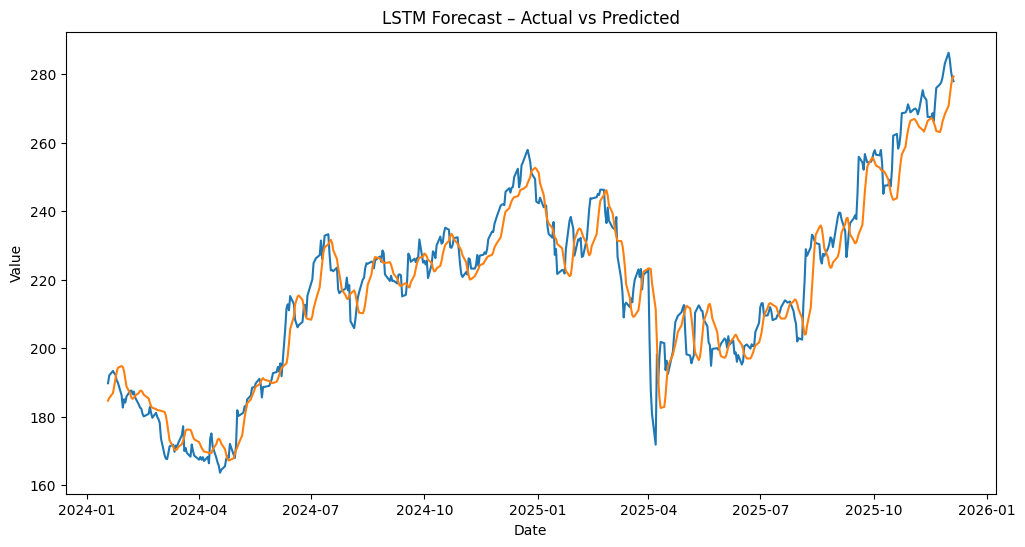

In [36]:
plt.figure(figsize=(12,6))

# Ensure all arrays have the same length for plotting
# Truncate dates_test and unscaled_y_test to match unscaled_prediction's length
N = len(y_test)
dates_test_trimmed = dates_test[-N:]
unscaled_y_test_trimmed = unscaled_y_test[-N:]

plt.plot(dates_test_trimmed, unscaled_y_test, label="Actual")
plt.plot(dates_test_trimmed, unscaled_prediction, label="Predicted")

plt.title("LSTM Forecast – Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Value")

# MONTHLY ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()
plt.show()